In [1]:
import radvel
import numpy as np
import rebound as rb
import reboundx
import matplotlib.pyplot as plt
import celmech as cm
import pandas as pd
# pd.set_option('display.max_rows', None)
import h5py
from tqdm import tqdm
from scipy import optimize

/home/ianchow/.local/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


Import data:

In [2]:
MAY_1_2015 = 57143.5  # barycentric julian date for May 1, 2015 (the date of the HARPS instrument upgrade as per trifonov et al 2020)
# 57143.5 is BJD for May 1, 2015
# 57173.5 is BJD for May 31, 2015

# harps
hd_data_harps = pd.read_csv('hd45364_rvs.csv', sep = ';')
# giant outlier at position 116 in the data (found manually earlier) which we remove
hd_data_harps.drop(116, inplace=True)  # drop the row and keep the df in place
# subtract 2.4e6 from all the rows in the data
hd_data_harps.BJD -= 2.4e6
# rename target to HARPS1 or HARPS2
hd_data_harps['target'] = hd_data_harps.apply(lambda row: 'HARPS1' if row.BJD < MAY_1_2015 else 'HARPS2', axis = 1)
# hires
hd_data_hires = pd.read_csv('hires_rvs.txt', sep = '\t', index_col=False, header='infer', dtype=np.float64)
hd_data_hires['BJD - 2,450,000'] += 50000.  # adding 50000 to have the same units as harps
hd_data_hires['target'] = 'HIRES'
hd_data_hires.columns = ['BJD', 'RV_mlc_nzp', 'e_RV_mlc_nzp', 'target']
# concatenate two data sets one on top of the other
hd_data = pd.concat((hd_data_harps, hd_data_hires), axis=0)  # matching BJD, RV_mlc_nzp and e_RV_mlc_nzp columns
# reset index
hd_data.reset_index(drop=True, inplace=True)

In [3]:
## CONSTANTS:

STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

obs_time_base = np.median(hd_data_harps.BJD)

# print(f'nbody_params:{nbody_params}\n fit_params:{fit_params}')

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))


def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i)
    params[5 * num_planets + 4] is jitter for HARPS1
    params[5 * num_planets + 5] is jitter for HARPS2
    params[5 * num_planets + 6] is jitter for HIRES
    
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = 2 # 2 planets
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * np.min([params[0], params[5]])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m = star_mass)  # star mass as a constant
    
    inclination = np.arcsin(params[-4])  # sin(i) is fourth from the back of the array
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(tc = params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, instrument, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i) (also params[-4])
    params[5 * num_planets + 4] is jitter for HARPS1 (also params[-3])
    params[5 * num_planets + 5] is jitter for HARPS2 (also params[-2])
    params[5 * num_planets + 6] is jitter for HIRES (also params[-1])

    param instrument: instrument (HARPS1, HARPS2, or HIRES)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards

    times = pd.Series(times)  # convert to series if not already
    
    forward_times = times[times - obs_time_base >= 0]
    backward_times = times[times - obs_time_base < 0]
    forward_indices = forward_times.index
    backward_indices = backward_times.index
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = 2  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for j, it in enumerate(zip(forward_indices, forward_times)):
        i, t = it  # forward index, forward time
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        # print(instrument[i])
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_forward[j] = (-star.vz * auday_ms) + rv_offset  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for j, it in enumerate(zip(backward_indices, backward_times)):
        i, t = it  # backward index, backward time
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        # print(instrument[i])
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_backward[j] = (-star.vz * auday_ms) + rv_offset
    
    return np.concatenate((rv_backward, rv_forward))

In [4]:
#Very original parameters used in Hadden and Payne
nbody_params =[ 2.27798546e+02,  7.25405874e+00,  5.39392010e+04,  1.71866112e-01, 1.17923823e-01,  
               3.43881599e+02,  1.87692753e+01,  5.40138425e+04, 1.68408461e-01,  5.05903191e-02, 
               -3.28526403e-03, 0., 0., 
               1, 
               1.84, 0., 0.]  # inserted 0 for harps2 and hires for both rv offset and jitter

# #Least squares fit: 
# fit_params = [ 2.28512793e+02, 7.27736501e+00, 5.39371914e+04, -4.66868256e-02, 
#                -1.78080009e-01, 3.43378038e+02, 1.78603341e+01, 5.40186750e+04, 
#                9.72945632e-02,  1.32194117e-01, -5.29072002e-01, 0., 0., 1, 2.428]#-7.68527759e-03] 

# Neg log likelihood jitter fit:

fit_params = [2.27859008e+02, 7.20396587e+00,  5.39386707e+04, -7.17270858e-03, -2.13670237e-01,
              3.44028221e+02, 1.82216479e+01,  5.47055869e+04, 1.14530821e-01,  3.81765820e-02,
              -1.38087163e-01, -2.89290650e+00, 1.70788055e+00, 
              1.00000000e+00,
              2.15025156e+00, 1.48605174e+00, 4.42809302e+00] 

Define a negative log-likelihood function to minimize for the least-squares fit with jitter, using equation (1) from this paper https://iopscience.iop.org/article/10.1088/0004-637X/794/1/51/pdf 

In [5]:
def neg_log_likelihood(params, data = hd_data):
    """
    Gets the negative log-likelihood (including a jitter term!) for use with scipy.optimize.minimze
    
    Iplements the log likelihood using the same method above
    
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    
    # inclination not handled sparately
    # inclination = np.arcsin(params[-4])  # inclination is np.arcsin of the second to last parameter
    
    synth_y = get_rvs(params, data.target, data.BJD, 'ias15', time_base = obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors

    conditions = [data.target == 'HARPS1', data.target == 'HARPS2', data.target == 'HIRES']  # conditions are harps1, harps2 or hires
    jitters = params[-3:]  # jitters for HARPS1, HARPS2 and HIRES, in that order
    
    # get the jitter values for the corresponding data points
    jitter = np.select(conditions, jitters, default=np.nan)

    # compute the log-likelihood
    log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2 + jitter ** 2) 
                                   + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))
    
    # log_likelihood = -1/2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2/variance))
    
    return -log_likelihood  # negative since we are trying to minimize the negative log likelihood

In [6]:
# test on fit_params
neg_log_likelihood(fit_params)

145.83699351667633

Now find the fit by maximizing the log likelihood (minimizing the negative log likelihood), with appropriate bounds (bounds of [0, 1] for sin(i))

In [7]:
# bounds of (0, 1) for sin(i), everything else can vary however
bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), 
          (None, None), (None, None), (None, None), (None, None), (None, None), 
          (None, None), (None, None), (None, None),
          (0, 1), 
          (None, None), (None, None), (None, None))

best_fit_jitter = optimize.minimize(neg_log_likelihood, x0=np.array(fit_params), method='Nelder-Mead', 
                                    bounds=bounds, options={'maxiter': np.inf, 'maxfev': np.inf})  # optimization

In [8]:
neg_log_likelihood(nbody_params), neg_log_likelihood(best_fit_jitter.x)

(1442.3439674247297, 145.83699351660437)

In [9]:
print(f'original guess:\n{np.array(fit_params)}\n\noptimization with jitter:\n{best_fit_jitter.x}\n\n', best_fit_jitter)

original guess:
[ 2.27859008e+02  7.20396587e+00  5.39386707e+04 -7.17270858e-03
 -2.13670237e-01  3.44028221e+02  1.82216479e+01  5.47055869e+04
  1.14530821e-01  3.81765820e-02 -1.38087163e-01 -2.89290650e+00
  1.70788055e+00  1.00000000e+00  2.15025156e+00  1.48605174e+00
  4.42809302e+00]

optimization with jitter:
[ 2.27859014e+02  7.20396610e+00  5.39386707e+04 -7.17559020e-03
 -2.13669346e-01  3.44028217e+02  1.82216589e+01  5.47055869e+04
  1.14531498e-01  3.81775332e-02 -1.38093056e-01 -2.89290989e+00
  1.70793414e+00  1.00000000e+00  2.15024775e+00  1.48604155e+00
  4.42811849e+00]

        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 145.83699351660437
             x: [ 2.279e+02  7.204e+00 ...  1.486e+00  4.428e+00]
           nit: 235
          nfev: 485
 final_simplex: (array([[ 2.279e+02,  7.204e+00, ...,  1.486e+00,
                         4.428e+00],
                       [ 2.279e+02,  7.204e+00, ...,  1.486e+0

**NBODY_VS_PREV_FINAL equivalent but using the jitter fit parameters instead of the original fit parameters without any jitter**:

In [10]:
# plt.figure(figsize=(14, 8))
# plt.rc('font', size = 18)
# # pltot the observed RVs
# plt.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed RVs')
# times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))  # time array
# # pltot the REBOUND n-body reuslt for original parameters and least-squares fit
# plt.plot(times, get_rvs(nbody_params, times, 'ias15', obs_time_base), label = 'Previous fit', color='darkgreen')#, color='black')
# # plt.plot(times, get_rvs(fit_params, np.pi/2, times, 'ias15', obs_time_base), label = 'New fit (no jitter)', color='orange')#, color='orange')
# plt.plot(times, get_rvs(best_fit_jitter.x, times, 'ias15', obs_time_base), label = 'New fit (jitter)', color='red')
# # pltot the Keplterian result
# # plt.pltot(times, post.model(times), label = 'Keplterian')
# plt.axvline(x = 54650, color='black', label='New data')
# plt.xlabel('BJD - 2.4e6'), plt.ylabel('Radial Velocity (m/s)')
# # plt.ylim(bottom = -30)
# # plt.title('N-body least-squares fit vs. previous fit')
# plt.legend(loc = 'lower left')
# plt.savefig('nbody_vs_prev_final_jitter.png', pad_inches=0)# fmt = 'png', pad_inches = 0)

Compare to the observed RV data:

In [11]:
# plt.figure(figsize=(14, 8))
# plt.rc('font', size = 18)
# # plot observed RVs
# plt.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed RVs')
# # plot the RV curve for original least-squares optimization (without jitter) and the nonlinear optimization (with jitter)
# times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))  # time array
# # original least squares optimization (no jitter)
# plt.plot(times, get_rvs(fit_params, times, 'ias15', obs_time_base), label = 'Least-squares (no jitter)', color='blue')
# # nonlinear optimization (jitter)
# plt.plot(times, get_rvs(best_fit_jitter.x, times, 'ias15', obs_time_base), label = 'Nonlinear (jitter)', color='orange')
# plt.axvline(x = 54650, c='k', label = 'New data')
# plt.xlabel('BJD - 2.4e6'), plt.ylabel('Radial Velocity (m/s)')
# plt.legend(loc = 'lower left')
# plt.show()


## Jitter:

Scale the best-fit jitter values simultaneously by a single factor:


Now changing jitter, holding the planet parameters constant and plotting likelihood as a function of jitter for the original solution without jitter as a parameter and the solution with jitter as a parameter

In [12]:
jitter_sfs = np.linspace(0., 2.5, int(1e3))  # try 1000 from 0 to 2.5
# get the best-fit jitter values
fit_param_jitters = np.array(fit_params[-3:])
# scale all of them simultaneously by a single factor from 0 to 2.5
# without jitter as a parameter set of params
# no_jitter_neg_log_likelihoods = [neg_log_likelihood(np.append(fit_params[:-3], jitter_sf * jitters)) for jitter_sf in jitter_sfs]
# jitter as a parameter set of params
# scale all of the best fit jitter values simultaneously by jitter_sf scale factor
jitter_neg_log_likelihoods = [neg_log_likelihood(np.append(best_fit_jitter.x[:-3], jitter_sf * fit_param_jitters)) for jitter_sf in jitter_sfs]  # compute negative log likelihood for each

And plot:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


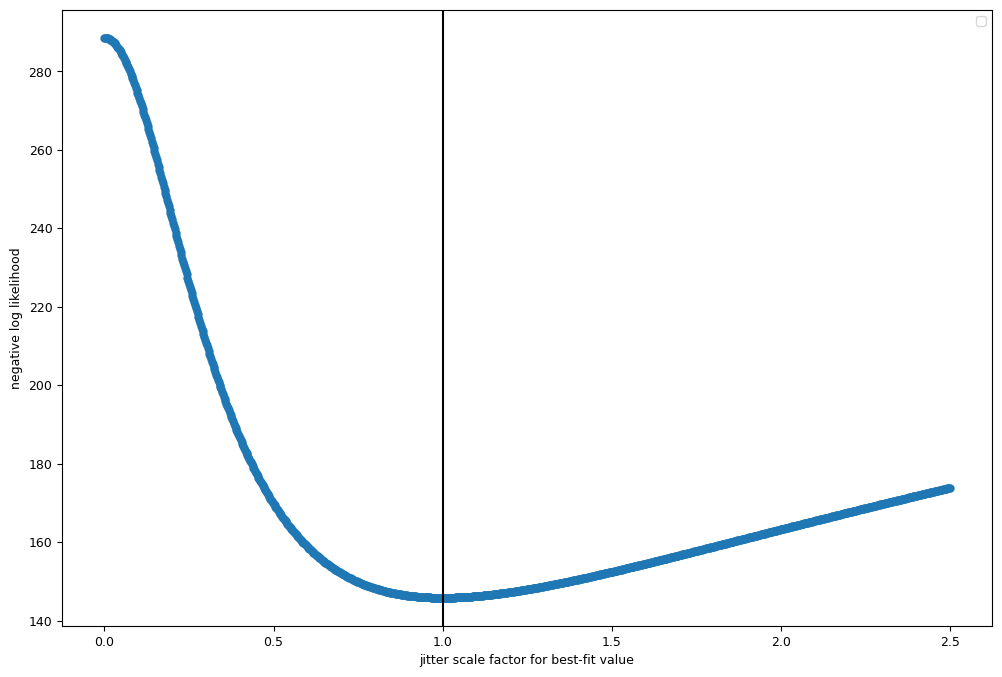

In [13]:
plt.figure(figsize = (12, 8))
# no jitter fit
# plt.scatter(jitters, no_jitter_neg_log_likelihoods, label = 'no jitter fit')
# jitter fit
plt.scatter(jitter_sfs, jitter_neg_log_likelihoods)#, label = 'jitter fit')
plt.xlabel('jitter scale factor for best-fit value'), plt.ylabel('negative log likelihood')
plt.axvline(1., color = 'k')
plt.legend()
plt.show()

In [14]:
# jitter that produces the minimum negative log likelihood for different values
# jitters[np.argmin(no_jitter_neg_log_likelihoods)], 
jitter_sfs[np.argmin(jitter_neg_log_likelihoods)]

1.001001001001001

In [15]:
# # minimum negative log likelihood
# neg_log_likelihood(params=np.append(best_fit_jitter.x[:-3], jitter_sfs[np.argmin(jitter_neg_log_likelihoods)]))

Try optimizing again with the jitter producing the minimum negative log likelihood

In [16]:
# best_fit_jitter2 = optimize.minimize(neg_log_likelihood, x0=np.append(best_fit_jitter.x[:-1], jitters[np.argmin(jitter_neg_log_likelihoods)]), method='Nelder-Mead', bounds=bounds, options={'maxiter': int(1e5), 'maxfev': int(1e5)})  # optimization

In [17]:
# plt.figure(figsize=(14, 8))
# plt.rc('font', size = 18)
# # plot observed RVs
# plt.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed RVs')
# # plot the RV curve for original least-squares optimization (without jitter) and the nonlinear optimization (with jitter)
# times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))  # time array
# # original least squares optimization (no jitter)
# # plt.plot(times, get_rvs(fit_params, np.pi/2, times, 'ias15', obs_time_base), label = 'Least-squares (no jitter)', color='blue')
# # nonlinear optimization (jitter)
# # plt.plot(times, get_rvs(best_fit_jitter.x, np.pi/2, times, 'ias15', obs_time_base), label = 'Nonlinear fit from LS solution (jitter)', color='orange')
# # nonlinear optimization (jitter) with the jitter producing the minimum negative log likelihood manually added
# plt.plot(times, get_rvs(best_fit_jitter2.x, times, 'ias15', obs_time_base), label = 'Nonlinear fit manual (jitter)')
# plt.axvline(x = 54650, c='k', label = 'New data')
# plt.xlabel('BJD - 2.4e6'), plt.ylabel('Radial Velocity (m/s)')
# plt.legend(loc = 'lower left')
# plt.show()

Check likelihood and compare:

In [18]:
neg_log_likelihood(fit_params), neg_log_likelihood(best_fit_jitter.x)# , neg_log_likelihood(best_fit_jitter2.x)

(145.83699351667633, 145.83699351660437)

In [19]:
fit_params, best_fit_jitter.x# , best_fit_jitter2.x

([227.859008,
  7.20396587,
  53938.6707,
  -0.00717270858,
  -0.213670237,
  344.028221,
  18.2216479,
  54705.5869,
  0.114530821,
  0.038176582,
  -0.138087163,
  -2.8929065,
  1.70788055,
  1.0,
  2.15025156,
  1.48605174,
  4.42809302],
 array([ 2.27859014e+02,  7.20396610e+00,  5.39386707e+04, -7.17559020e-03,
        -2.13669346e-01,  3.44028217e+02,  1.82216589e+01,  5.47055869e+04,
         1.14531498e-01,  3.81775332e-02, -1.38093056e-01, -2.89290989e+00,
         1.70793414e+00,  1.00000000e+00,  2.15024775e+00,  1.48604155e+00,
         4.42811849e+00]))

Create a 2D grid of $S$ and jitter scale factors, then for each point hold them constant while optimizing the parameters using least-squares (or nonlinear) and compute the likelihood 

In [20]:
njitter, nlib = (50, 50)  # can change this
# create jitter and A_0 points
jitter_sfs = np.linspace(0., 4, njitter)  # use 1 to 6 for jitter as recommended
Alibs = np.linspace(1., 0.05, nlib)  # use Alib 1 to 0.05
# create meshgrid
jitter_sfs_grid, Alibs_grid = np.meshgrid(jitter_sfs, Alibs)

Optimize the parameters using least squares while holding $A_{0}$ and jitter constant for each point, then compute the likelihood ($\chi^2$) just of the fit for each point:

In [21]:
def get_rvs_jitter(params, jitter_sf, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params, taking into account a jitter term
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i) (also params[-4])
    
    param jitter: constant jitter scale factor
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """

    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards

    times = pd.Series(times)  # convert to series if not already
    
    forward_times = times[times - obs_time_base >= 0]
    backward_times = times[times - obs_time_base < 0]
    forward_indices = forward_times.index
    backward_indices = backward_times.index
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = 2  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for j, it in enumerate(zip(forward_indices, forward_times)):
        i, t = it  # forward index, forward time
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        # print(instrument[i])
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_forward[j] = (-star.vz * auday_ms) + rv_offset  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for j, it in enumerate(zip(backward_indices, backward_times)):
        i, t = it  # backward index, backward time
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        # print(instrument[i])
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_backward[j] = (-star.vz * auday_ms) + rv_offset
    
    return np.concatenate((rv_backward, rv_forward))


def get_nbody_resids_jitter_libration(params, jitters, Alib, nperiods=500, nsamples=1000, integrator='ias15', data=hd_data, time_base=obs_time_base):
    """
    Gets the normalized residuals for the n-body fit with REBOUND, penalizing for the RMS of the libration angle a 
    and for jitter, holding each of them constant (this is the function we want to optimize)
    
    params is in the form of params for the 10-param model (n-body rebound) rather than the 7-param equilibrium model (keplerian)
    
    Alib is 0.01 by default
    """

    obs_y = data.RV_mlc_nzp  # observed RVs
    synth_y = get_rvs(params, data.target, data.BJD, 'ias15', time_base = obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y error

    # get numpy array of jitters corresponding to each instrument
    conditions = [data.target == 'HARPS1', data.target == 'HARPS2', data.target == 'HIRES']  # conditions are harps1, harps2 or hires
    # get the jitter values for the corresponding data points
    jitter = np.select(conditions, jitters, default=np.nan)

    # then first compute the normalized residuals taking into account jitter, as follows:
    jitter_normalized_resids = (obs_y - synth_y)/np.sqrt(obs_yerr ** 2 + jitter ** 2)  # compute normalized residuals using rebound
    
    # define p1
    p1 = params[0]

    angle_times = np.linspace(0, 0 + p1 * nperiods, nsamples)  # angle times, use length of observed rvs
    angle_time_base = 0#np.median(angle_times)  # reset angle time base to something else to find the libration amplitude 
    # initialize sim
    angle_sim = get_sim_from_params(params, integrator='whfast', time_base=0)
    inner = angle_sim.particles[1]
    outer = angle_sim.particles[2]
    # define empty arrays
    angle1, angle2 = np.zeros((2, nsamples))  # init empty arrays
    # now compute the libration angle arrays
    # test2 = np.zeros(len(angle_times))
    for i, t in enumerate(angle_times):
        angle_sim.integrate(t, exact_finish_time = 0)
        resonant_angle = 3 * outer.l - 2 * inner.l  # 3*lambda_2 - 2*lambda_1
        # test2[i] = resonant_angle
        angle1[i] = np.mod(resonant_angle - inner.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_1, mod 2pi
        angle2[i] = np.mod(resonant_angle - outer.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_2, mod 2pi
    
    # now return the rms libration amplitude for inner and outer to penalize by
    # compute the normalized "residuals" A_lib_resids_1 (inner planet) and A_lib_resids_2 (outer planet)
    A_lib_normalized_resids_1 = np.array([(angle - 0)/(Alib * np.sqrt(len(angle1))) 
                     for angle in [angle - 2 * np.pi if angle > np.pi else angle for angle in angle1]])  # since inner planet oscillates around 0
    A_lib_normalized_resids_2 = np.array([(angle - np.pi)/(Alib * np.sqrt(len(angle2))) for angle in angle2])  # since outer planet oscillates around pi

    # return normalized residuals plus the "residuals" used for the RMS libration amplitude penalty
    return np.concatenate((jitter_normalized_resids, A_lib_normalized_resids_1, A_lib_normalized_resids_2))  # concatenate all 3 arrays to pass to the least squares optimizer

Test to make sure it's computing residuals properly

In [22]:
test_jitters = best_fit_jitter.x[-3:]

test_resids = get_nbody_resids_jitter_libration(best_fit_jitter.x, jitters=jitter_sfs_grid[0, 1] * test_jitters, Alib=Alibs_grid[0, 1])
neg_log_likelihood(best_fit_jitter.x), (test_resids @ test_resids)/2  # neg log likelihood has an extra constant term added to it so it may be higher than the test resids

(145.83699351660437, 224.54633160381871)

In [23]:
test_resids

array([ 3.5524189 , -1.07620185, -0.02548022, ..., -0.01950902,
       -0.0198855 , -0.01906373])

And optimize the fit

In [24]:
bounds2 = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf],
          [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1, np.inf, np.inf, np.inf])

fit_param_jitters = np.array(fit_params[-3:])  # fit param jitters are the last 3 entries in the array
test_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, 
                                                                                          jitters = fit_param_jitters * jitter_sfs_grid[0, 1], 
                                                                                          Alib=Alibs_grid[0, 1]), fit_params, bounds=bounds2)
test_fit_params.x

array([ 2.27859008e+02,  7.20401250e+00,  5.39386707e+04, -6.69675119e-03,
       -2.11502032e-01,  3.44028360e+02,  1.82216583e+01,  5.47055869e+04,
        1.14551494e-01,  3.72067252e-02, -1.38080314e-01, -2.89291055e+00,
        1.70788969e+00,  9.99818337e-01,  2.15025156e+00,  1.48605174e+00,
        4.42809302e+00])

In [25]:
test_fit_params

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.539e+00 -1.086e+00 ...  1.509e-02  1.404e-02]
           x: [ 2.279e+02  7.204e+00 ...  1.486e+00  4.428e+00]
        cost: 224.09683467998485
         jac: [[ 3.590e-01 -1.194e+00 ...  0.000e+00  0.000e+00]
               [ 5.832e-01 -6.314e-01 ...  0.000e+00  0.000e+00]
               ...
               [-7.047e-01  1.330e-02 ...  0.000e+00  0.000e+00]
               [-6.985e-01  1.428e-02 ...  0.000e+00  0.000e+00]]
        grad: [-5.893e+00 -4.273e+00 ...  0.000e+00  0.000e+00]
  optimality: 37.73917176294161
 active_mask: [0 0 ... 0 0]
        nfev: 3
        njev: 3

### Computing likelihoods over the $A_0$-jitter grid:

Test for a single iteration of the loop:

In [26]:
njitter, nlib = (50, 50)  # can change this
# create jitter and A_0 points
jitter_sfs = np.linspace(0., 4, njitter)  # use 0 to 4 for jitter scale factor as recommended
Alibs = np.linspace(1., 0.05, nlib)  # use Alib 1 to 0.05
# create meshgrid
jitter_sfs_grid, Alibs_grid = np.meshgrid(jitter_sfs, Alibs)

x0 = fit_params
best_fit_jitters = best_fit_jitter.x[-3:]  # these are the best fit jitter values
neg_log_likelihoods = np.zeros((njitter, nlib))

Alib = Alibs_grid[0, 1]  
jitters = jitter_sfs_grid[0, 1] * best_fit_jitters
# optimize the parameters, holding Alib and jitter scale factor constant at the specified grid point
Alib_jitter_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitters=jitters, Alib=Alib), 
                                                x0, bounds=bounds2, ftol=1e-8, xtol=1e-8).x
# then compute the negative log likelihood of fit just from the parameters (not the total cost function including the libration penalty term)
# assuming the jitter scale factor used in the optimization
Alib_jitter_fit_params[-3:] = jitters
# plug params into negative log likelihood and record it
neg_log_likelihoods[0, 1] = neg_log_likelihood(Alib_jitter_fit_params)
# update fit params with previous value
x0 = Alib_jitter_fit_params

Now optimize the parameters for each given value of $A_0$ and jitter, computing the likelihood $\mathfrak{L}$, for a jitter scale factor from $0.1$ to $4$, to show the contours for high jitter. We save the best-fit parameters as well as the corresponding likelihoods for each point on the grid:

In [27]:
njitter, nlib = (50, 50)  # can change this
# create jitter and A_0 points
jitter_sfs = np.linspace(0.1, 4, njitter)  # use 0.1 to 4 for jitter scale factor as recommended
Alibs = np.linspace(1., 0.05, nlib)  # use Alib 1 to 0.05
# create meshgrid
jitter_sfs_grid, Alibs_grid = np.meshgrid(jitter_sfs, Alibs)

x0 = fit_params
best_fit_jitters = best_fit_jitter.x[-3:]  # these are the best fit jitter values 
# they are constant and are scaled by some uniform jitter scaling factor in the loop, and held constant during the optimization procedure

### LOOP:
# S_params = np.zeros((njitter, nlib, len(x0)))
# neg_log_likelihoods = np.zeros((njitter, nlib))
# for i in tqdm(range(njitter)):
#     # add something here to reset the original guess which could maybe speed it up a bit
#     for j in range(nlib):
#         # get the A0, jitter scale factor point on the grid and then multiply the best-fit jitters by the scale factor
#         Alib = Alibs_grid[i, j]  
#         jitters = jitter_sfs_grid[i, j] * best_fit_jitters
#         # optimize the parameters, holding Alib and jitter scale factor constant at the specified grid point
#         Alib_jitter_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitters=jitters, Alib=Alib), 
#                                                         x0, bounds=bounds2, ftol=1e-8, xtol=1e-8).x
#         # then compute the negative log likelihood of fit just from the parameters (not the total cost function including the libration penalty term)
#         # assuming the jitter scale factor used in the optimization
#         Alib_jitter_fit_params[-3:] = jitters
#         # save parameters
#         S_params[i, j] = Alib_jitter_fit_params
#         # plug params into negative log likelihood and record it
#         neg_log_likelihoods[i, j] = neg_log_likelihood(Alib_jitter_fit_params)
#         # update fit params with previous value
#         x0 = Alib_jitter_fit_params

Save/load the best-fit parameters over the grid (uncomment following code if need to save/load...):

In [28]:
# np.save('S_params', S_params)  # save the best-fit parameters
S_params = np.load('S_params.npy')

Confirm that libration amplitudes are actually going down as we expect for the S-jitter factor grid:

In [29]:
def get_resonant_angles(params, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets resonant angles theta_1, theta_2 from an array of parameters
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i) (also params[-4])
    params[5 * num_planets + 4] is jitter for HARPS1 (also params[-3])
    params[5 * num_planets + 5] is jitter for HARPS2 (also params[-2])
    params[5 * num_planets + 6] is jitter for HIRES (also params[-1])

    param instrument: instrument (HARPS1, HARPS2, or HIRES)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards

    times = pd.Series(times)  # convert to series if not already
    
    forward_times = times[times - obs_time_base >= 0]
    backward_times = times[times - obs_time_base < 0]
    forward_indices = forward_times.index
    backward_indices = backward_times.index
    
    # initialize libration angle for inner and outer planets
    resonant_angle1_forward = np.zeros(len(forward_times))
    resonant_angle1_backward = np.zeros(len(backward_times))
    resonant_angle2_forward = np.zeros(len(forward_times))
    resonant_angle2_backward = np.zeros(len(backward_times))
    
    num_planets = 2  # find number of planets in params passed

    inner = sim.particles[1]
    outer = sim.particles[2]

    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specifided time
        resonant_angle1_forward[i] = np.mod(3 * outer.l - 2 * inner.l - inner.pomega, 2 * np.pi)  # theta1
        resonant_angle2_forward[i] = np.mod(3 * outer.l - 2 * inner.l - outer.pomega, 2 * np.pi)  # theta1
    
    for i, t in enumerate(backward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time
        resonant_angle1_backward[i] = np.mod(3 * outer.l - 2 * inner.l - inner.pomega, 2 * np.pi)  # theta1
        resonant_angle2_backward[i] = np.mod(3 * outer.l - 2 * inner.l - outer.pomega, 2 * np.pi)  # theta1

    # concatentate forward and backward libration angle to get the libration angle for every timestep, for both inner and outer planet
    resonant_angles_inner = np.concatenate((resonant_angle1_backward, resonant_angle1_forward))
    resonant_angles_outer = np.concatenate((resonant_angle2_backward, resonant_angle2_forward))
    
    return resonant_angles_inner, resonant_angles_outer

0.05 0.9755102040816326


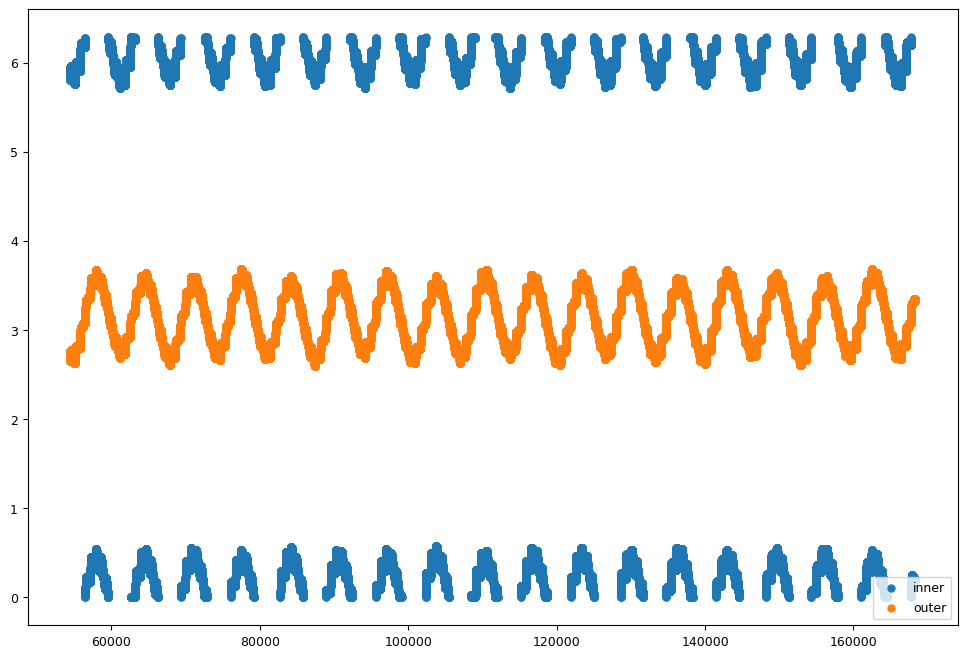

In [30]:
sim1 = get_sim_from_params(best_fit_jitter.x, 'ias15', obs_time_base)  # start sim
angle_times = np.linspace(0, 500 * sim1.particles[1].P, int(1e5)) + sim1.t   # angle times

grid_i, grid_j = (49, 11)

inner_angles, outer_angles = get_resonant_angles(S_params[grid_i][grid_j], angle_times, 'ias15', obs_time_base)

plt.figure(figsize = (12, 8))
plt.scatter(angle_times, inner_angles, label = 'inner')
plt.scatter(angle_times, outer_angles, label = 'outer')
plt.legend()

print(Alibs_grid[grid_i, grid_j], jitter_sfs_grid[grid_i, grid_j])# * best_fit_jitters)

Save/load the neg log likelihoods (uncomment following code if need to save/load...):

In [31]:
# np.save('neg_log_likelihoods_everything_contours', neg_log_likelihoods) # save the neg log likelihood array in numpy
neg_log_likelihoods = np.load('neg_log_likelihoods_everything_contours.npy')

And computing neg log likelihoods for $0.02$-$2$ jitter scale factor to show the contours for low jitter:

In [32]:
njitter_02, nlib_02 = (50, 50) 
# create jitter, A_0 points
jitter_sfs_02 = np.linspace(0.02, 2., njitter_02)  # use 0 to 0.5 for jitter
Alibs_02 = np.linspace(1., 0.05, nlib_02)
# Alibs_05 = 1.05 - np.geomspace(1, 0.05)  # use Alib 1 to 0.05
# create meshgrid
jitter_sfs_grid_02, Alibs_grid_02 = np.meshgrid(jitter_sfs_02, Alibs_02)
# this now takes only ~40 minutes, not too bad...

x0_02 = fit_params
best_fit_jitters_02 = best_fit_jitter.x[-3:]

# # same as before
# neg_log_likelihoods_02 = np.zeros((njitter_02, nlib_02))
# for i in tqdm(range(njitter_02)):
#     # add something here to reset the original guess which could maybe speed it up a bit
#     for j in range(nlib_02):
#         # get the A0, jitterpoint on the grid
#         Alib_02 = Alibs_grid_02[i, j]  
#         jitters_02 = jitter_sfs_grid_02[i, j] * best_fit_jitters
#         # optimize the parameters, holding A0 and jitter constant at the specified grid point
#         # set the f and x tolerance to be much lower!
#         Alib_jitter_fit_params_02 = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitters=jitters_02, Alib=Alib_02), 
#                                                            x0_02, bounds=bounds2, ftol=1e-8, xtol=1e-8).x
#         # then compute the negative log likelihood of fit just from the parameters (not the total cost function including the libration penalty term)
#         # add jitter back to the parameters
#         Alib_jitter_fit_params_02[-3:] = jitters_02 
#         # plug params into negative log likelihood and record it
#         neg_log_likelihoods_02[i, j] = neg_log_likelihood(Alib_jitter_fit_params_02)
#         # update fit params with previous value
#         x0_02 = Alib_jitter_fit_params_02

Optional: Save/load:

In [33]:
# save
# np.save('neg_log_likelihoods_everything_02', neg_log_likelihoods_02)

# load
neg_log_likelihoods_02 = np.load('neg_log_likelihoods_everything_02.npy')

And for $0.5$-$2$ jitter scale factor:

Plot:

### Plot:

In [34]:
import matplotlib.colors
import matplotlib.cm

def rgb_white2alpha(rgb, ensure_increasing=False):
    """
    Convert a set of RGB colors to RGBA with maximum transparency.
    
    The transparency is maximised for each color individually, assuming
    that the background is white.
    
    Parameters
    ----------
    rgb : array_like shaped (N, 3)
        Original colors.
    ensure_increasing : bool, default=False
        Ensure that alpha values are strictly increasing.
    
    Returns
    -------
    rgba : numpy.ndarray shaped (N, 4)
        Colors with maximum possible transparency, assuming a white
        background.
    """
    # The most transparent alpha we can use is given by the min of RGB
    # Convert it from saturation to opacity
    alpha = 1. - np.min(rgb, axis=1)
    if ensure_increasing:
        # Let's also ensure the alpha value is monotonically increasing
        a_max = alpha[0]
        for i, a in enumerate(alpha):
            alpha[i] = a_max = np.maximum(a, a_max)
    alpha = np.expand_dims(alpha, -1)
    # Rescale colors to discount the white that will show through from transparency
    rgb = (rgb + alpha - 1) / alpha
    # Concatenate our alpha channel
    return np.concatenate((rgb, alpha), axis=1)

def cmap_white2alpha(name, ensure_increasing=False, register=True):
    """
    Convert colormap to have the most transparency possible, assuming white background.
    
    Parameters
    ----------
    name : str
        Name of builtin (or registered) colormap.
    ensure_increasing : bool, default=False
        Ensure that alpha values are strictly increasing.
    register : bool, default=True
        Whether to register the new colormap.

    Returns
    -------
    cmap : matplotlib.colors.ListedColormap
        Colormap with alpha set as low as possible.
    """
    # Fetch the cmap callable
    cmap = plt.get_cmap(name)
    # Get the colors out from the colormap LUT
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    # Convert white to alpha
    rgba = rgb_white2alpha(rgb, ensure_increasing=ensure_increasing)
    # Create a new Colormap object
    cmap_alpha = matplotlib.colors.ListedColormap(rgba, name=name + "_alpha")
    if register:
        matplotlib.cm.register_cmap(name=name + "_alpha", cmap=cmap_alpha)
    return cmap_alpha

# Get original Reds colormap
cmap_og = plt.get_cmap("Reds")

In [35]:
# from matplotlib.ticker import MultipleLocator
# # load data
# neg_log_likelihoods_02 = np.load('neg_log_likelihoods_everything_02.npy')
# # minimum neg log likelihood at zero jitter
# min_neg_log_likelihood_02 = neg_log_likelihoods_02[5, 0] 
# # locations of contour labels
# # manual_locations = [(2.4, 0.7), (1.7, 0.6), (2.0, 0.6), (3.3, 0.6), (3.9, 0.6)]
# # levels
# levels_02 = [min_neg_log_likelihood_02 + 1, min_neg_log_likelihood_02 + 4, min_neg_log_likelihood_02 + 9]

# import scipy.ndimage
# sigma = 1.
# neg_log_likelihoods_02 = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods_02, sigma)

# njitter_02, nlib_02 = (50, 50) 
# jitters_02 = np.linspace(0., 0.2, njitter_02)  # use 0 to 0.5 for jitter
# Alibs_02 = np.linspace(1.1, 0.05, nlib_02)
# jitters_grid_02, Alibs_grid_02 = np.meshgrid(jitters_02, Alibs_02)

# # plotting
# fig_, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 9), dpi=100)
# fig3 = plt.contourf(jitters_grid_02, Alibs_grid_02, neg_log_likelihoods_02, cmap=plt.get_cmap('Blues_r'), alpha=1., 
#                     antialiased=True, levels=levels_02, extend='min')
# plt.scatter(jitters_grid_02[5, 0], Alibs_grid_02[5, 0], label = 'Best fit', color='red', s=50)
# plt.annotate(f'{np.round(min_neg_log_likelihood_02, 2)}', xy=(jitters_grid_02[5, 0], Alibs_grid_02[5, 0]), 
#               xycoords='data', textcoords='axes fraction', xytext=(0.005, 0.95), color='red')
# plt.xlabel('jitter (m/s)'), plt.ylabel(r'$S$')
# # plt.clabel(fig3, inline=True, fontsize=14)#, manual=manual_locations)
# plt.ylim(top=1.)
# plt.tick_params('both', length=6, width=1.5, which='major')
# plt.tick_params('both', length=3, width=0.75, which='minor')
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# # save
# plt.savefig('2021_fall-2022_winter/paper_figures/Alib_jitter_sini_contour_0_02.png')#, fmt='png')

#### Figure in paper; Alib-jitter plot 

Methodology: 
- Take full set of planet parameters, but hold A_lib and jitter constant across a grid of values
- Optimize the function `get_nbody_results_jitter_libration()` which is the same least-squares function for RVs used, but with an additional penalty for the RMS libration amplitude, for each set of parameters
- Then compute the negative log-likelihood of each set of parameters following Eq. 1 of (https://iopscience.iop.org/article/10.1088/0004-637X/794/1/51/pdf), which takes into account all parameters (including jitter) but not libration
- Plot the best-fit point (lowest log-likelihood) and likelihood contours of best fit $\mathcal{L}$ + ($1$, $4$, $9$) corresponding to ($1, 2, 3 \sigma$) from best-fit likelihood

Results strongly suggests nonzero jitter but shows that A_lib doesn't matter until a very strong penalty is applied (below $A \approx 0.3$) and that the fit is better with a weaker penalty

In [36]:
np.min(neg_log_likelihoods)

145.90280775244878

<a list of 4 text.Text objects>

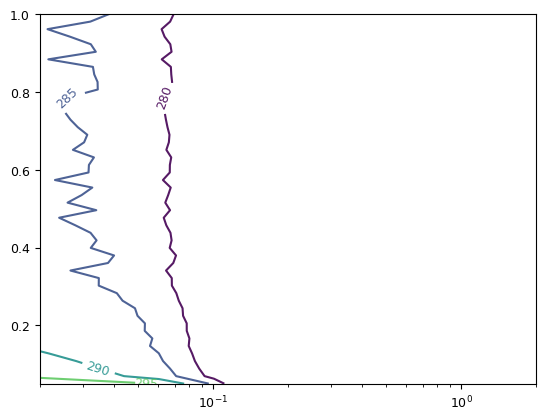

In [37]:
levels2 = [280, 285, 290, 295, 300]

fig = plt.contour(jitter_sfs_grid_02, Alibs_grid_02, neg_log_likelihoods_02, levels = levels2, alpha = 0.9, antialiased=True)
plt.xscale('log')
plt.xlim(left=2e-2)
plt.clabel(fig)

In [38]:
min_likelihood = np.min(neg_log_likelihoods)
min_likelihood_index = tuple(np.argwhere(neg_log_likelihoods == min_likelihood).reshape(-1))
jitter_sfs_grid[min_likelihood_index], Alibs_grid[min_likelihood_index]

(0.9755102040816326, 1.0)

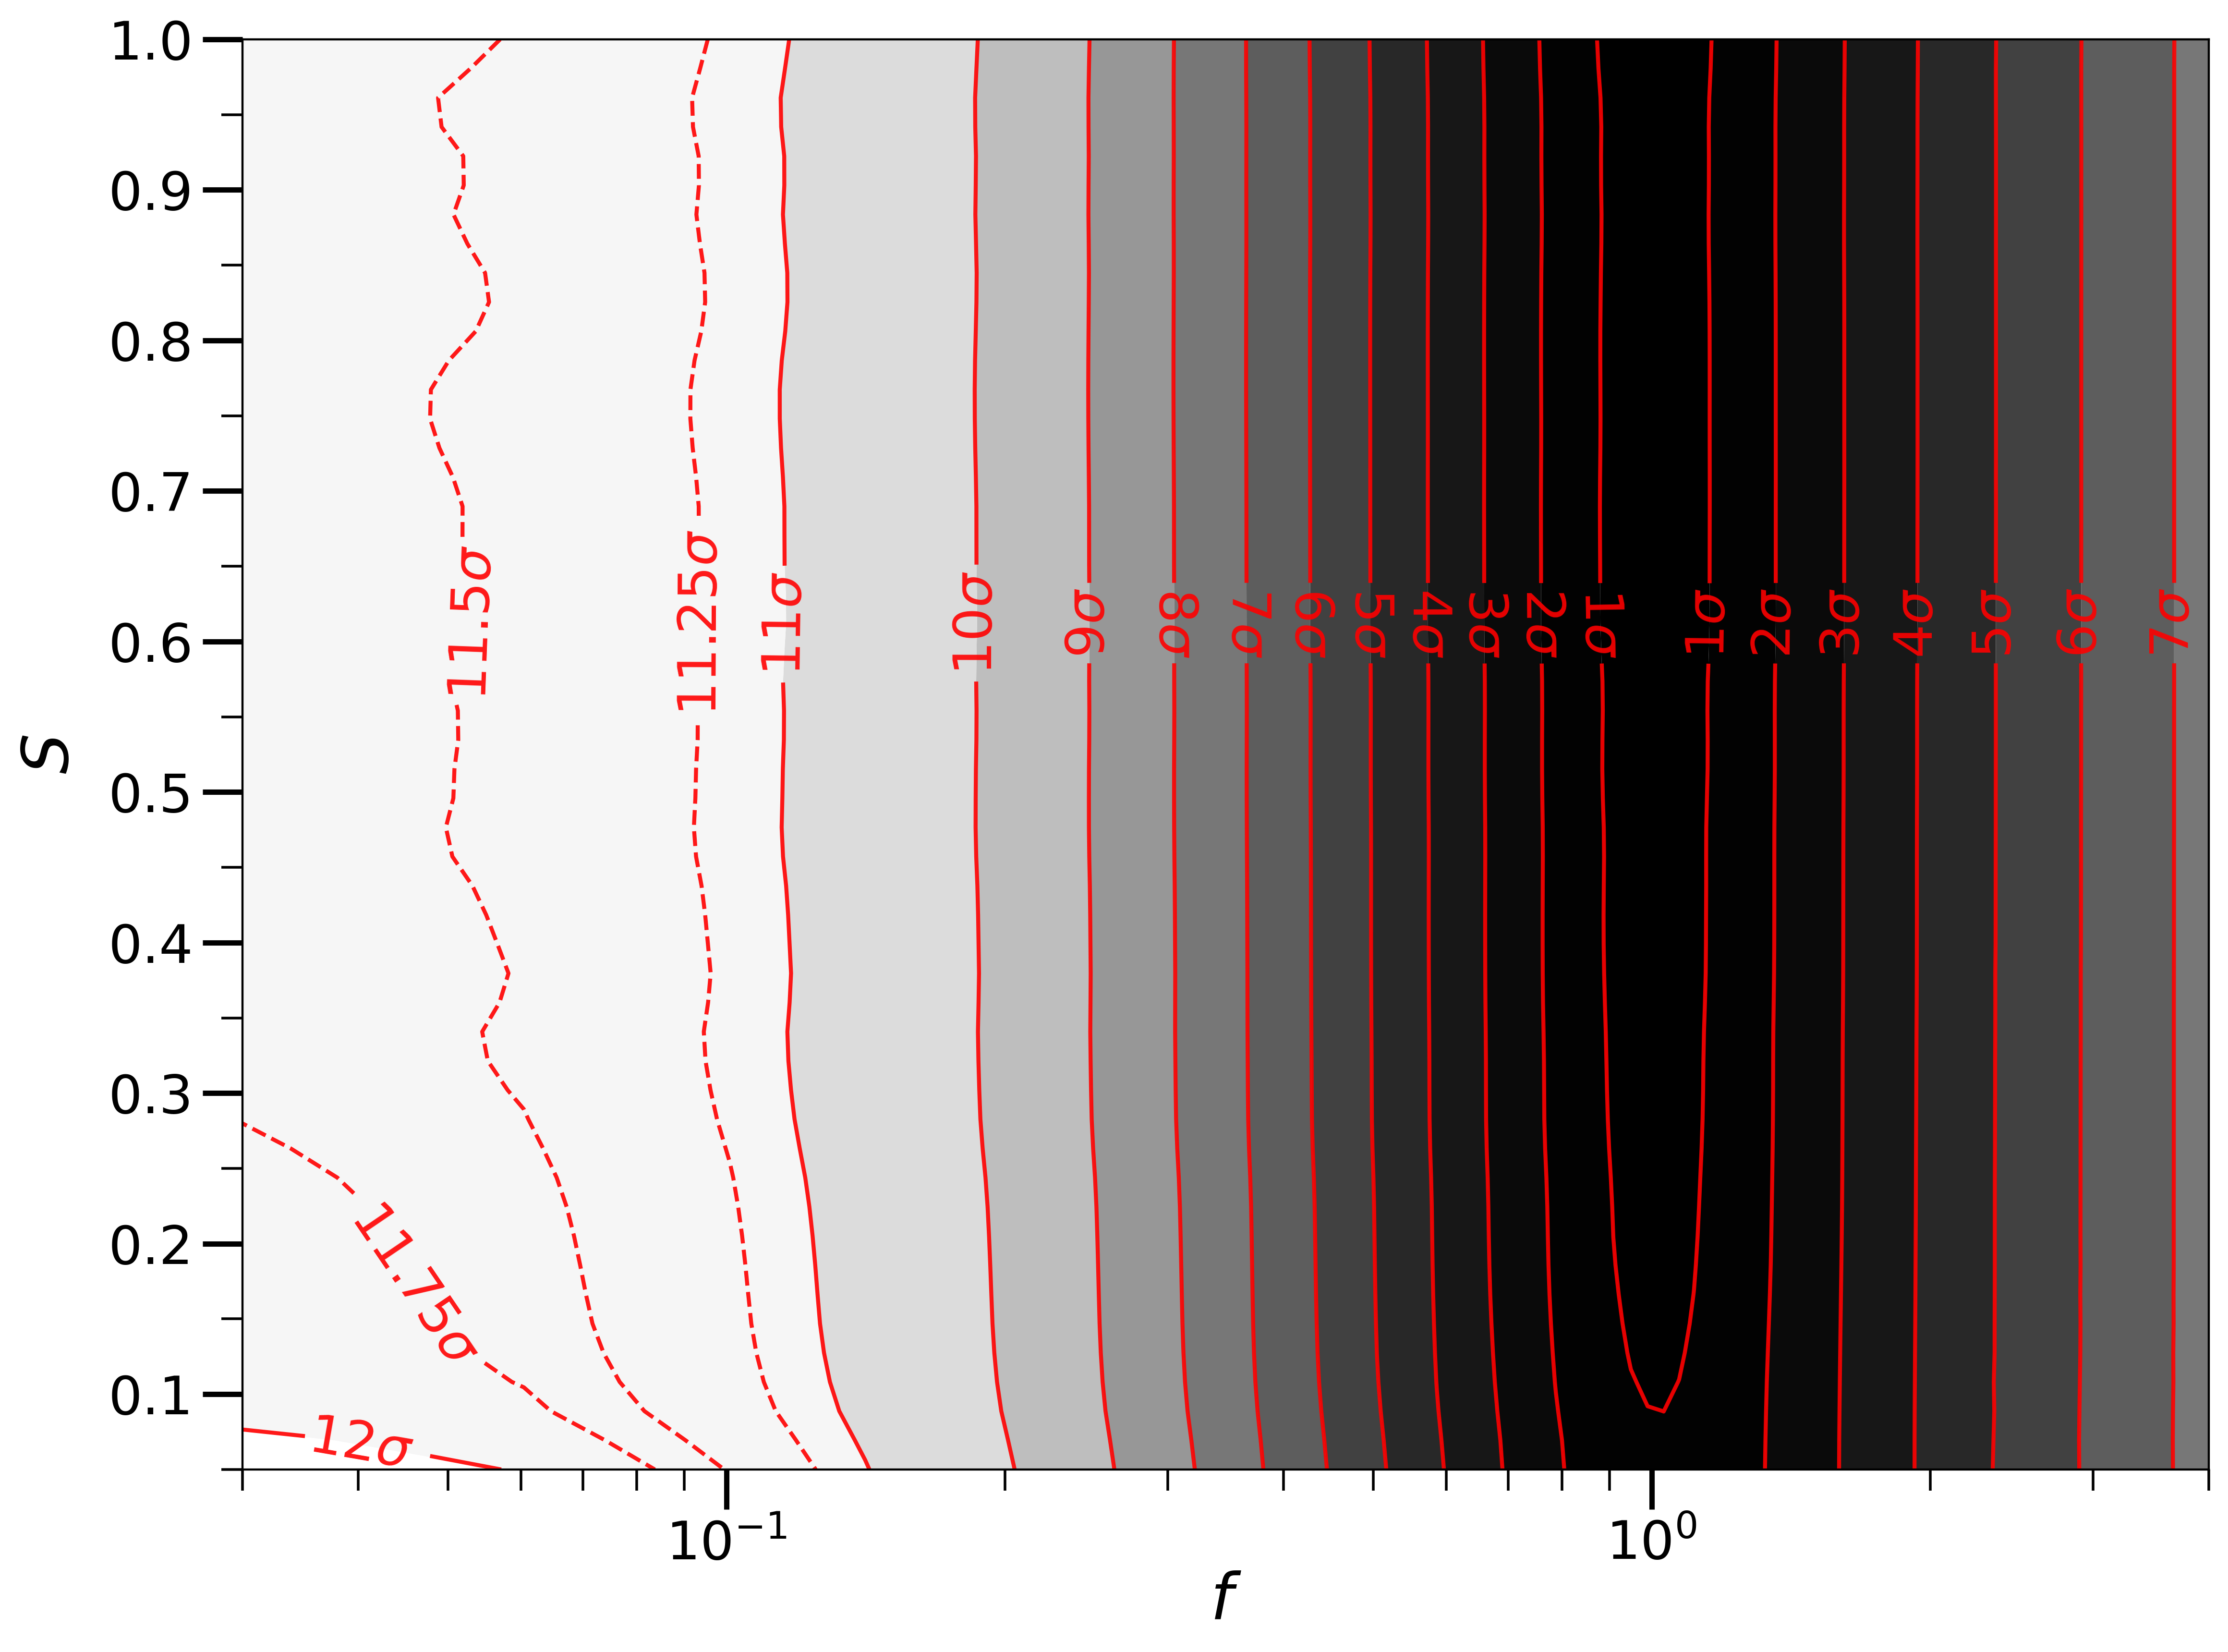

In [39]:
from matplotlib.ticker import MultipleLocator
import scipy.ndimage

neg_log_likelihoods = np.load('neg_log_likelihoods_everything_contours.npy')
neg_log_likelihoods_02 = np.load('neg_log_likelihoods_everything_02.npy')

# neg_log_likelihoods = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods, sigma=1.2)# [5:,:]

neg_log_likelihoods = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods, sigma=0.)
neg_log_likelihoods_02 = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods_02, sigma=1.)

# neg_log_likelihoods = scipy.ndimage.zoom(neg_log_likelihoods, zoom=3)

# jitters_0_05 = np.linspace(0., 0.2, 50)
# Alibs_0_05 = np.linspace(1.1, 0.05, 50)
# jitters_grid_0_05, Alibs_grid_0_05 = np.meshgrid(jitters_0_05, Alibs_0_05)
# neg_log_likelihoods_0_05 = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods_02, sigma=1.)

# min_likelihood = 144.46
min_likelihood = np.min(neg_log_likelihoods)
min_likelihood_index = tuple(np.argwhere(neg_log_likelihoods == min_likelihood).reshape(-1))

# min_likelihood_zero_jitter = np.min(neg_log_likelihoods_0_05[:,0])

# levels
levels = [min_likelihood + 1., min_likelihood + 4., min_likelihood + 9.]
levels_intermediate = [min_likelihood + 16., min_likelihood + 25., min_likelihood + 36., min_likelihood + 49., min_likelihood + 64., 
           min_likelihood + 81.]
# levels = [min_likelihood + 1, min_likelihood + 4, min_likelihood + 9, 
#                             min_likelihood + 16, min_likelihood + 25, min_likelihood + 36, 
#                             min_likelihood + 49, min_likelihood + 64, min_likelihood + 81, 
#                             min_likelihood + 100]
levels2_solid = [min_likelihood + 100., min_likelihood + 11. ** 2, min_likelihood + 12. ** 2]#, min_likelihood + 11.5 ** 2]#, min_likelihood + 11.5 ** 2]
levels2_dashed = [min_likelihood + 11.25 ** 2, min_likelihood + 11.59 ** 2, min_likelihood + 11.75 ** 2]

njitter, nlib = (50, 50)  # can change this
# create jitter and A_0 points
jitter_sfs = np.linspace(0.1, 4, njitter)  # use 0 to 4 for jitter scale factor as recommended
Alibs = np.linspace(1., 0.05, nlib)  # use Alib 1 to 0.05
# create meshgrid
jitter_sfs_grid, Alibs_grid = np.meshgrid(jitter_sfs, Alibs)

njitter_02, nlib_02 = (50, 50) 
# create jitter, A_0 points
jitter_sfs_02 = np.linspace(0.02, 2., njitter_02)  # use 0 to 0.5 for jitter
Alibs_02 = np.linspace(1., 0.05, nlib_02)
# Alibs_05 = 1.05 - np.geomspace(1, 0.05)  # use Alib 1 to 0.05
# create meshgrid
jitter_sfs_grid_02, Alibs_grid_02 = np.meshgrid(jitter_sfs_02, Alibs_02)
# this now takes only ~40 minutes, not too bad...

# stitched jitter sfs
stitching_index = -26  # index to start stitching the two arrays together
stitched_jitter_sfs = np.concatenate((jitter_sfs_02, jitter_sfs[stitching_index:]))
# do not need to stitch alibs since they are the same
stitched_Alibs = Alibs
stitched_jitter_sfs_grid, stitched_Alibs_grid = np.meshgrid(stitched_jitter_sfs, stitched_Alibs)
# stitch neg log likelihoods
stitched_neg_log_likelihoods = np.concatenate((neg_log_likelihoods_02.T, neg_log_likelihoods.T[stitching_index:]))
# stitched levels
stitched_levels = np.concatenate((levels, levels_intermediate, levels2_solid))


# plotting
plt.rc('font', size=20)
fig_, ax = plt.subplots(nrows=1, ncols=1, figsize = (12, 9), dpi=400)
plt.xscale('log')

fig_shaded = plt.contourf(stitched_jitter_sfs_grid, stitched_Alibs_grid, stitched_neg_log_likelihoods.T, 
                   levels = stitched_levels, cmap=plt.get_cmap('Greys_r'), alpha=1., antialiased=True, 
                   extend='min', label='negative log likelihoods')
fig = plt.contour(stitched_jitter_sfs_grid, stitched_Alibs_grid, stitched_neg_log_likelihoods.T, 
                  levels = stitched_levels, colors = 'r', alpha = 0.9, antialiased=True, linewidth=2., linestyles='solid')
figdashed = plt.contour(stitched_jitter_sfs_grid, stitched_Alibs_grid, stitched_neg_log_likelihoods.T, 
                  levels = levels2_dashed, colors = 'r', alpha = 0.9, antialiased=True, linewidth=2., linestyles='dashed')

# fig = plt.contourf(jitter_sfs_grid, Alibs_grid, neg_log_likelihoods, levels = levels, cmap=plt.get_cmap('Greys_r'), alpha=1., 
#                    antialiased=True, extend='min', label='negative log likelihoods')
# # fig2 = plt.contourf(jitter_sfs_grid_02, Alibs_grid_02, neg_log_likelihoods_02, levels = levels2, cmap=plt.get_cmap('Greys_r'), alpha=1., 
# #                    antialiased=True, extend='min', label='negative log likelihoods')
# fig = plt.contour(jitter_sfs_grid, Alibs_grid, neg_log_likelihoods, levels = levels, colors = 'r', alpha = 0.9, antialiased=True)
# fig2 = plt.contour(jitter_sfs_grid_02, Alibs_grid_02, neg_log_likelihoods_02, levels = levels2, colors='r', alpha = 0.9, antialiased=True)
# fig_intermediate = plt.contour(jitter_sfs_grid, Alibs_grid, neg_log_likelihoods, levels = levels_intermediate, 
#                                colors = 'r', alpha = 0.9, antialiased=True)
# # fig3 = plt.contour(jitters_grid_02, Alibs_grid_02, neg_log_likelihoods_02, levels = levels2)
# # fig2 = plt.contour(jitters_grid_05, Alibs_grid_05, neg_log_likelihoods_05, levels = [396, 397, 397.5])

# plt.scatter(jitter_sfs_grid[min_likelihood_index], Alibs_grid[min_likelihood_index], label = 'Best fit', color='red', s=150)
# plt.annotate(f'{np.round(min_likelihood, 2)}', xy=(jitters_grid[min_likelihood_index], Alibs_grid[min_likelihood_index]), 
#               xycoords='data', textcoords='axes fraction', xytext=(0.45, 0.95), color='red')
# plt.clabel(fig, inline=True, fontsize=28, colors='k')#, manual=manual_locations)

low_fmt = {}
high_fmt = {}
int_fmt = {}
strs_low_dashed = [r'$11.25\sigma$', r'$11.5\sigma$', r'$11.75\sigma$']
strs_low_solid = [r'$10\sigma$', r'$11\sigma$', r'$12\sigma$']
strs_intermediate = [r'$4\sigma$', r'$5\sigma$', r'$6\sigma$', r'$7\sigma$', r'$8\sigma$', r'$9\sigma$']
strs_high = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(levels2_solid, strs_low_solid):
    low_fmt[l] = s
for l, s in zip(levels, strs_high):
    high_fmt[l] = s
for l, s in zip(levels_intermediate, strs_intermediate):
    int_fmt[l] = s
    
total_fmt = {**low_fmt, **int_fmt, **high_fmt}

low_dashed_fmt = {}
for l, s in zip(levels2_dashed, strs_low_dashed):
    low_dashed_fmt[l] = s

# Basic contour plot
# plt.clabel(fig3, inline=True, fontsize=14)
# yticks
ax.tick_params('both', length=15, width=2., which='major')
ax.tick_params('both', length=8, width=1., which='minor')
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlabel(r'$f$', fontsize=24, labelpad=0)
plt.ylabel(r'$S$', fontsize=24, labelpad=10)

# locations of contour labels
location_06 = Alibs_grid[20][0]  # location where Alib = 0.6 as an approximate place to put the labels
n_contours = 18
manual_locations = np.concatenate((np.array([[4e-2, 0.06]]), np.c_[[1.1e-1, 
                          2.e-1, 2.5e-1, 3.e-1, 3.5e-1, 4.e-1, 5.e-1, 6.e-1, 7.e-1, 8.e-1, 9.e-1, 
                          1.1, 1.3, 1.6, 1.9, 2.3, 2.9, 3.6], np.ones(n_contours) * location_06]))
plt.gca().clabel(fig, inline=True, fmt=total_fmt, fontsize=20, manual=manual_locations)
plt.gca().clabel(figdashed, inline=True, fmt=low_dashed_fmt, fontsize=20, manual=[(4.5e-2, 0.17), (6e-2, location_06), (1.e-1, location_06)])
# plt.gca().clabel(fig, inline=True, fmt=high_fmt, fontsize=16)
# plt.gca().clabel(fig2, inline=True, fmt=low_fmt, fontsize=16)
# plt.gca().clabel(fig_intermediate, inline=True, fmt=int_fmt, fontsize=16)
plt.xlim(left=3e-2)
plt.ylim(top=1.0)
# plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('2021_fall-2022_winter/paper_figures/Alib_jitter_sini_contour_05_5.png')#, fmt='png')

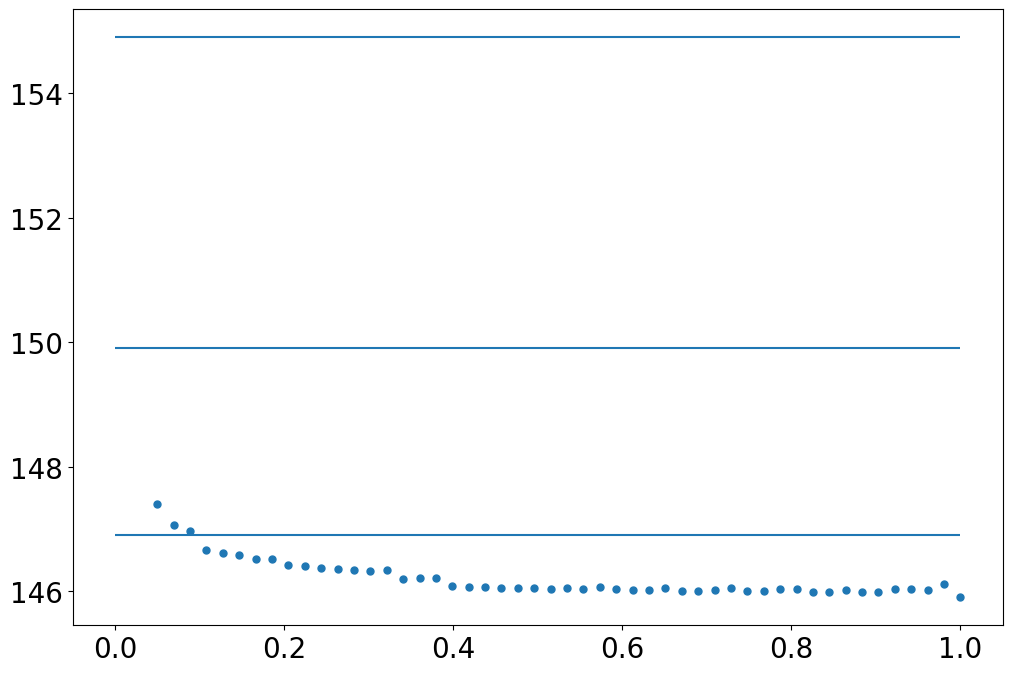

In [40]:
# neg_log_likelihoods = np.load('neg_log_likelihoods_everything_contours.npy')
fig, ax = plt.subplots(1, 1, figsize = (12, 8), dpi=100)
plt.scatter(Alibs, neg_log_likelihoods[:,min_likelihood_index[-1]])
ax.hlines(levels, cmap=plt.get_cmap('Blues_r'), alpha=1., xmin=0., xmax=1.)

In [41]:
# fig, ax = plt.subplots(1, 1, figsize = (12, 8), dpi=100)
# plt.scatter(Alibs_02[5:], neg_log_likelihoods_02[5:, 5])
# ax.hlines(levels_02, cmap=plt.get_cmap('Blues_r'), alpha=1., xmin=0., xmax=1.)

Finding the approximate value of $1\sigma_\text{jit}$:

In [42]:
# jitter_range = jitters_grid[0][[np.argwhere(neg_log_likelihoods[0] < np.min(neg_log_likelihoods[0] + 1))]]
# onesigma_jit = (np.max(jitter_range) - np.min(jitter_range))/2
# onesigma_jit

### Testing/Debugging:

Optional: Now compute and plot the likelihood for varying $A_0$ while holding jitter at $0$:

In [ ]:
nlib = 150
Alibs = np.linspace(1.1, 0.05, nlib)

neg_log_likelihoods_zero_jitter = np.zeros(nlib)

x0 = fit_params
for j in tqdm(range(nlib)):
    # get the A0, jitter point on the grid
    Alib = Alibs[j]  
    jitter = 0.
    # optimize the parameters, holding A0 and jitter constant at the specified grid point
    Alib_jitter_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=jitter, Alib=Alib), 
                                                    x0, bounds=bounds2, ftol=1e-12, xtol=1e-12, verbose=0).x
    # then compute the negative log likelihood of fit just from the parameters (not the total cost function including the libration penalty term)
    # add jitter back to the parameters
    Alib_jitter_fit_params[-1] = jitter 
    # plug params into negative log likelihood and record it
    neg_log_likelihoods_zero_jitter[j] = neg_log_likelihood(Alib_jitter_fit_params)
    # update fit params with previous value
    x0 = Alib_jitter_fit_params

Optional: Save/load:

In [ ]:
# save
# np.save('neg_log_likelihoods_zero_jitter', neg_log_likelihoods_zero_jitter)

# load
neg_log_likelihoods_zero_jitter = np.load('neg_log_likelihoods_zero_jitter.npy')

Plot:

In [ ]:
plt.figure()
plt.scatter(Alibs, neg_log_likelihoods_zero_jitter)
plt.xlim(right=1.)
# plt.ylim(396, 399)

In [ ]:
Alibs[75]

In [ ]:
test_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=0., Alib=Alibs[75]), 
                                                fit_params, bounds=bounds2, verbose=0).x

In [ ]:
test_fit_params

In [ ]:
test_fit_params[-1] = 0
neg_log_likelihood(test_fit_params)

In [ ]:
%matplotlib widget
sim = get_sim_from_params(test_fit_params, integrator='ias15', time_base=obs_time_base)
op = rb.OrbitPlot(sim, orbit_style='solid', color=True)
fig = op.fig
for i in range(100):
    op.sim.integrate(sim.t+1000)
    op.update()       # update data
    op.fig.savefig("op_frames/out_%02d.png"%i)

In [ ]:
plt.scatter(cluster2samples[200:].reshape(-1, 13)[:,-1], cluster2log_prob[200:].reshape(-1))
plt.ylim(-180, -140)

In [ ]:
testdata = h5py.File('mcmc_hd45364_test_everything_with_libration_penalty.h5', 'r')
clusterdata = h5py.File('2021_fall-2022_winter/mcmc_hd45364_cluster_everything.h5', 'r')

In [ ]:
testdata, clusterdata

In [ ]:
clusteraccepted, clustersamples, clusterlog_prob = np.array(clusterdata['mcmc']['accepted']), np.array(clusterdata['mcmc']['chain']), np.array(clusterdata['mcmc']['log_prob'])

In [ ]:
testaccepted, testsamples, testlog_prob = np.array(testdata['mcmc']['accepted']), np.array(testdata['mcmc']['chain']), np.array(testdata['mcmc']['log_prob'])

In [ ]:
clusterlog_prob[0], testlog_prob[0]

#### extra:

Testing to make sure I can get a jacobian that's nonzero for every parameter:

In [ ]:
# jacobian_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration2(params, Alib=1, integrator='ias15'), best_fit_jitter2.x, bounds=bounds2)
jacobian_fit_params = optimize.least_squares(lambda params: get_nbody_resids(params, integrator='ias15'), best_fit_jitter2.x, bounds=bounds2)

In [ ]:
jacobian_fit_params.x, best_fit_jitter2.x

In [ ]:
j = jacobian_fit_params.jac
j[-1][-1] = onesigma_jit
np.linalg.inv(j.T @ j)

In [ ]:
neg_log_likelihood(jacobian_fit_params.x), neg_log_likelihood(best_fit_jitter2.x)

In [ ]:
# obs_yerr = hd_data.e_RV_mlc_nzp
# jitter_penalties = [np.sum(np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2)))) for jitter in jitters]

# plt.plot(jitters, jitter_penalties)

# fit_params = np.array([ 2.28306953e+02,  7.26248510e+00,  5.39345613e+04,  4.02153494e-02,
#        -1.76686411e-01,  3.43427379e+02,  1.79425723e+01,  5.40193481e+04,
#         1.01456416e-01,  1.18819868e-01, -4.99414710e-01,  1.00000000e+00])

# result = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=1, Alib=1), fit_params)

# result2 = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=2, Alib=1), result.x)

# result3 = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=3, Alib=1), result2.x)

# result3